In [1]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os

# strfpy
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep, calcSegmentedModel
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt

import pynwb
from matplotlib import pyplot as plt
# %matplotlib widget
plt.ion();

In [2]:
nwb_file = '/aquila_ssd2/lthomas/songephys_data/OperantEphys/HpiPur2667F/sites/HpiPur2667F_site03_240905_133829_pb_op/HpiPur2667F_site03_240905_133829_pb_op_ks4_lat_250215.nwb'

# Load the nwb file
preprocOptions = {} # we'll leave this empty and use default options
nwb_io =  pynwb.NWBHDF5IO(nwb_file, mode='r')
nwb = nwb_io.read()
units = nwb.units.to_dataframe()
# load the good units
good_units = units[units.group == 'good']


In [3]:
# sample a random unit
unit = good_units.sample().iloc[0]
unit = good_units.loc[73]
print("Processing unit: ", unit.name)

respChunkLen = 350 # ms of stim to use in each chunk
segmentBuffer = 100 # ms to add at the beginning of each segment
nLaguerre = 25 # number of laguerre functions to use
feature = 'spect_windows'
event_types = 'onoff_feature'
nPoints = 150 # number of points to use in the kernel
mult_values = False
srData = preprocSound.generate_srData_nwb(nwb, 'playback_trials',unit.name)
calcSegmentedModel.preprocess_srData(srData, plot=False, respChunkLen=respChunkLen, segmentBuffer=segmentBuffer, tdelta=0)
srData, pca, ridge, ridge_conv_filter, laguerre_args, r2s = calcSegmentedModel.process_unit(srData, feature=feature, nLaguerre=nLaguerre,nPoints=nPoints,  plot=False, do_test_set=False)
kernels = ridge_conv_filter.coef_.reshape((2,nPoints))
results = dict({
    'uid': unit.name,
    'kernel_0': kernels[0,:],
    'kernel_1': kernels[1,:],
    'laguerre_args': laguerre_args,
    'r2_seg': r2s[0],
    'r2_segid': r2s[2],
})


Processing unit:  73
Fitting PCA
Fitting convolutional kernel
Fitting laguerre parameters
Fit the laguerre convolved features to the response


/mnt/aquila_ssd/lthomas/miniconda3/envs/ks4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/aquila_ssd/lthomas/miniconda3/envs/ks4/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


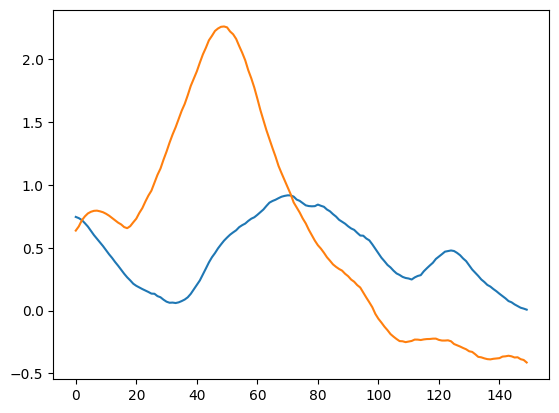

In [4]:
# learned kernels for this neuron
learned_conv_kernel = ridge_conv_filter.coef_.reshape(2, nPoints)
for i in [0,1]:
    plt.plot(learned_conv_kernel[i])

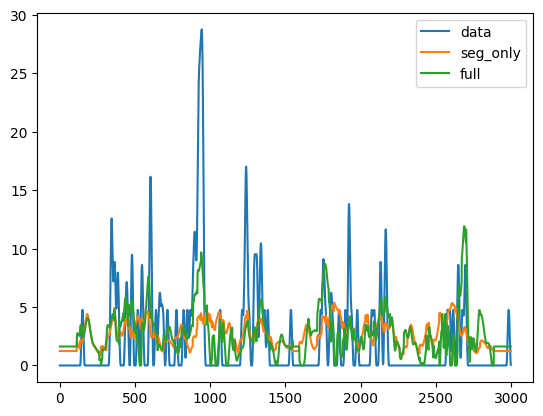

In [5]:
# pick some random pair
pair = srData['datasets'][2]
y = pair['resp']['psth_smooth']

# get the pred for the seg only version
x = calcSegmentedModel.arbitrary_kernel(pair, nPoints=nPoints, resp_key='psth')
y_pred_1 = ridge_conv_filter.predict(x.T)


# get the pred for the full version
y_pred_2 = calcSegmentedModel.generate_prediction(
        pair, ridge, feature, laguerre_args, ridge_conv_filter, nPoints, nLaguerre
    )

# plot the results
plt.figure()
plt.plot(y,label='data')
plt.plot(y_pred_1,label='seg_only')
plt.plot(y_pred_2,label='full')
plt.legend()